/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_57702/304117999.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,12_ema,27_ema,MACD,Signal,MACD_HIST,BB_SMA,BB_STD,Upper Band,Lower Band,MACD_Strategy,BB_Strategy,Confl_Strategy,Strategy,asset_cum_returns,strategy_cum_returns
7276,431.646179,432.044623,428.003119,431.171822,107134800,438.219953,438.144088,0.075865,0.462712,-0.386847,437.923785,5.848689,449.621163,426.226408,NaN,NaN,NaN,0,NaN,NaN
7277,439.311707,439.454008,432.907884,435.089916,69806300,438.393101,438.249783,0.143319,0.398238,-0.254920,437.787495,5.779128,449.345752,426.229239,-1.0,0.0,-1.0,0,0.017759,0.000000
7278,443.704346,443.818187,438.856399,439.055650,58890200,439.231464,438.734287,0.497176,0.418173,0.079003,437.841534,5.831544,449.504623,426.178446,-1.0,0.0,-1.0,0,0.027935,0.000000
7279,446.465027,447.973479,444.605555,444.709899,56439700,440.368708,439.409233,0.959475,0.527076,0.432399,437.974518,6.002521,449.979561,425.969475,1.0,0.0,1.0,0,0.034331,0.000000
7280,452.783447,452.830871,447.802697,447.850121,56808600,442.313967,440.558641,1.755326,0.773892,0.981434,438.918336,6.764923,452.448182,425.388491,1.0,0.0,1.0,0,0.048969,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8252,681.440002,682.179993,675.030029,677.239990,75842900,676.609722,672.604123,4.005599,5.025814,-1.020215,674.614499,8.282299,691.179097,658.049901,-1.0,0.0,-1.0,0,0.578700,-0.020574
8253,683.000000,683.570007,678.729980,679.950012,58953400,677.592842,673.346685,4.246156,4.869883,-0.623726,675.653000,7.942900,691.538801,659.767199,-1.0,0.0,-1.0,0,0.582314,-0.020574
8254,683.380005,684.960022,680.950012,684.789978,62312500,678.483174,674.063351,4.419823,4.779871,-0.360047,676.563501,7.718523,692.000547,661.126455,-1.0,0.0,-1.0,0,0.583195,-0.020574
8255,672.039978,680.859985,670.520020,680.500000,103457800,677.491913,673.918824,3.573089,4.538514,-0.965425,677.133499,6.853133,690.839765,663.427233,-1.0,0.0,-1.0,0,0.556923,-0.020574


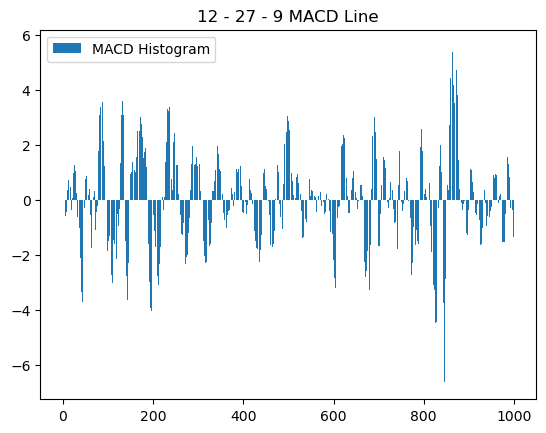

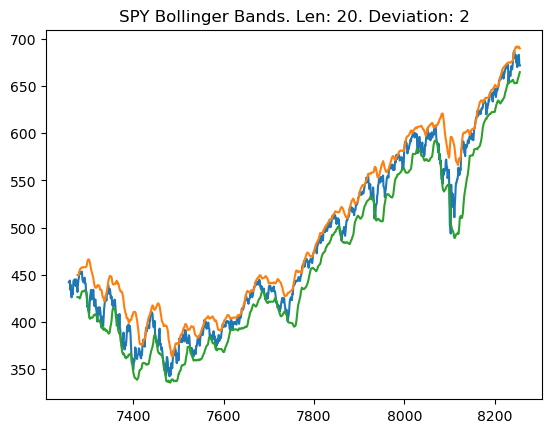

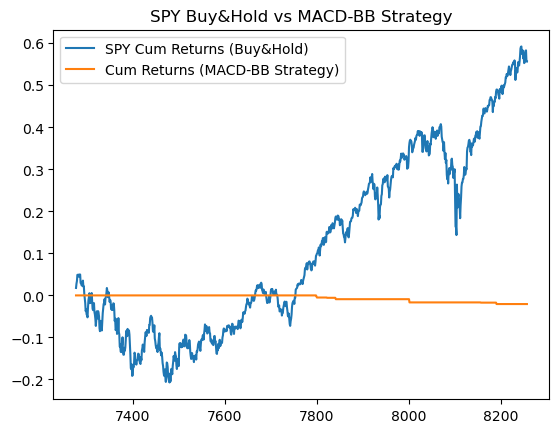

In [42]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

# Step 4: BB
BB_LENGTH = 20
STD_DEV = 2

# Step 5: Data Subsection
LOOKBACK = 1000

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):
    
    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 1 from Multilevel Column (MultiIndex)
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    # Step 4: Return Subsect Data 
    return df.iloc[-lookback:, :]

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

def add_bollinger_bands(df, std_dev = STD_DEV, length = BB_LENGTH):
        
    # Step 1: Build the BB Columns
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
        # It calculates the middle Bend
        # rolling(window=length): it takes the Close price and creates a moving window of length periods
        # mean(): it calculates the average price within that window at each step
    df["BB_STD"] = df["Close"].rolling(window=length).std()
        # std. dev/volatility: quantifies how spread out/ inconsistent your data is. 
        # It measures the average distance of each data point from the mean of the entire set
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
        # It takes the middle band's value and adds the volatility * std_dev factor (typically 2). 
        # This places the upper line 2 std_dev above the middle band.
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])
        
    # Step 2: Plot the BB
    plt.figure()
    plt.plot(df["Close"]) # Blue
    plt.plot(df["Upper Band"]) # Orange
    plt.plot(df["Lower Band"]) # Green
    plt.title(f"{TICKER} Bollinger Bands. Len: {BB_LENGTH}. Deviation: {STD_DEV}")

    return df.dropna()
    # Drop na, since it takes us 20 days to get the first rollings average values 

def add_MACD_strategy(df): 

    # Step 1: Long when Bullish Momentum, Short for Bearish Momentum
    df["MACD_Strategy"] = np.where(df["MACD_HIST"] > 0, 1, -1)

    # Step 2: Shift the signal to prevent lookahead bias - we can only understand Data after it happens:
    df["MACD_Strategy"] = df["MACD_Strategy"].shift(1)
    
    return df

def add_BB_strategy(df):
    df["BB_Strategy"] = np.where(df["Close"] > df["Upper Band"], -1, 
                    np.where(df["Close"] < df["Lower Band"], 1, 0))
    # Short Signal: -1 (Close > Upper Band) --> Multilple Leverage: -3
    # Long Signal: 1 (Close < Lower Band) --> Multilple Leverage: 3
    # Hold Signal: 0 (Close not > Upper Band, nor < Lower Band)

    # Shift the signal to prevent lookahead bias - we can only understand Data after it happens:
    df["BB_Strategy"] = df["BB_Strategy"].shift(1)
    
    return df 

def add_confluence_strategy(df):
    
    # Step 1: Place trades, when those agree with each other/there is a confluence
    df["Confl_Strategy"] = df["MACD_Strategy"] + df["BB_Strategy"]

    # Adjust for Simplicity
    df["Strategy"] = np.where(df["Confl_Strategy"] == 2, 1,
                    np.where(df["Confl_Strategy"] == -2, -1, 0))

    return df 

def test_strategy(df):
    
    # Step 1: Test Strategy 
    df["asset_cum_returns"] = (1 + df["Close"].pct_change()).cumprod() - 1 
    df["strategy_cum_returns"] = (1 + df["Close"].pct_change() * df["Strategy"]).cumprod() - 1

    # Step 2: Plot Returns
    plt.figure()
    plt.plot(df["asset_cum_returns"])
    plt.plot(df["strategy_cum_returns"])
    plt.legend([f"{TICKER} Cum Returns (Buy&Hold)", "Cum Returns (MACD-BB Strategy)"])
    plt.title(f"{TICKER} Buy&Hold vs MACD-BB Strategy")
    # In this graph we can recognize the compunding effect 

    return df 

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_bollinger_bands(df)
    df = add_MACD_strategy(df)
    df = add_BB_strategy(df)
    df = add_confluence_strategy(df)
    df = test_strategy(df)

    return df


df = main()
df


In [43]:
# Testing Values
df["MACD_Strategy"].value_counts()

MACD_Strategy
 1.0    501
-1.0    479
Name: count, dtype: int64

In [44]:
# Testing Values
df["BB_Strategy"].value_counts()

BB_Strategy
 0.0    880
-1.0     50
 1.0     50
Name: count, dtype: int64

In [45]:
# Testing Values
df["Confl_Strategy"].value_counts()

Confl_Strategy
 1.0    458
-1.0    422
 0.0     93
-2.0      7
Name: count, dtype: int64

In [46]:
df["Strategy"].value_counts()

Strategy
 0    974
-1      7
Name: count, dtype: int64